# Objetivo
Implementar un AG para encontrar los valores que minimizan la funcion Ackley en 2 variables.
$f(x) = -20\exp\left(-0.2\sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2}\right) - \exp\left(\frac{1}{n} \sum_{i=1}^{n} \cos(n\pi x_i)\right) + 20 + e$

In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:


def ackley_fitness(X, a=20.0, b=0.2):
    """
    Función de Ackley (variante con cos(n*pi*x_i)) para usar como función objetivo.

    Acepta:
      - X shape (r,)        -> r individuos 1D (n=1)
      - X shape (r,n)       -> r individuos de n variables
      - (x1, x2, ..., xn)   -> tuplas/listas de arrays (se apilan por columnas)

    Retorna:
      - ndarray shape (r,) con f(x) por individuo.
    """
    # Si me pasan (x1, x2, ...) los convierto en matriz de (r,n)
    if isinstance(X, (list, tuple)) and len(X) > 0 and np.ndim(X[0]) == 1:
        X = np.column_stack(X)

    X = np.asarray(X, dtype=float)

    # Si es solo un vector 1D, conviértelo en matriz (r,1) para unificar lógica
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n = X.shape[1]  # número de variables (1 o 2)
    sum_sq = np.sum(X**2, axis=1)
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / n))
    term2 = -np.exp(np.sum(np.cos(n * np.pi * X), axis=1) / n)
    return term1 + term2 + a + np.e

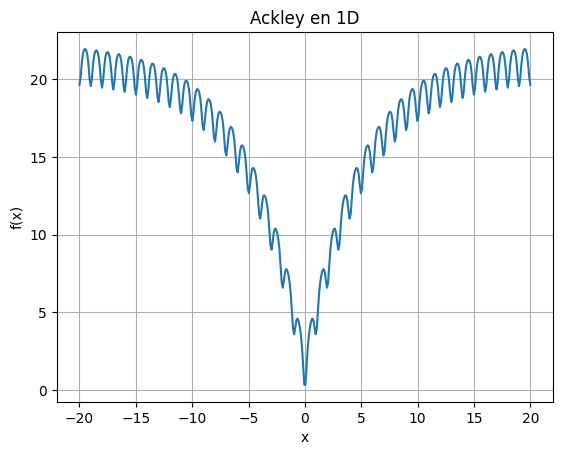

In [68]:

def funcion(X):
    return ackley_fitness(X)


# Dominio en 1D
x = np.linspace(-20, 20, 400)
x1 = np.linspace(-20, 20, 400)



y = funcion((x,x1))

# Graficar
plt.plot(x, y)
plt.title("Ackley en 1D")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

In [69]:
# FUNCION PARA INICIAR POBLACION
def iniciar_población(numero_individuos, longitud_cromosoma):
    return  np.random.randint(0,2,size=(numero_individuos,longitud_cromosoma))

In [70]:
# FUNCIÓN PARA DECODIFICAR DE BINARIO A DECIMAL LOS INDIVIDUOS
def decodificar(poblacion, min, max):
    [renglones,columnas] = poblacion.shape
    decimal = np.zeros(renglones)
    decimal_rescalado = np.zeros(renglones)
    
    for i in range(renglones):
        for j in range(columnas):
            # Se transforma de binario a decimal entero
            decimal[i] += poblacion[i,j]*2**(columnas-j-1)
            
            # Se rescalan los valores al rango de busqueda
            decimal_rescalado[i] = (max-min)*decimal[i]/(2**columnas-1) + min
            
    return decimal_rescalado



In [71]:
# Mantén esto: fx = -ackley_fitness
def fx(X):
    return -ackley_fitness(X)

# Mantén fitness así: NO lo niegues aquí
def fitness(poblacion_x1, poblacion_x2, xmin, xmax):
    x1 = decodificar(poblacion_x1, xmin, xmax)
    x2 = decodificar(poblacion_x2, xmin, xmax)
    X  = np.column_stack((x1, x2))
    return fx(X)  # mayor es mejor

In [72]:
def cruzamiento(poblacion_x1: np.ndarray, poblacion_x2: np.ndarray, pares_de_cromosomas: int):
    r, c = poblacion_x1.shape
    assert poblacion_x2.shape == (r, c), "P1 y P2 deben tener mismas dimensiones"

    if pares_de_cromosomas > r // 2:
        raise ValueError("pares_de_cromosomas debe ser <= N//2")

    # Emparejamiento por permutación: cada padre se usa a lo mucho una vez
    perm = np.random.permutation(r)
    hijos_x1 = np.zeros((2 * pares_de_cromosomas, c), dtype=int)
    hijos_x2 = np.zeros((2 * pares_de_cromosomas, c), dtype=int)

    for k in range(pares_de_cromosomas):
        i = perm[2 * k]
        j = perm[2 * k + 1]

        # Punto de corte en [1, c-1] para asegurar recombinación real
        p = np.random.randint(1, c)

        # ======= x1 con el MISMO p y los MISMOS padres i, j =======
        # hijo A
        hijos_x1[2 * k, :p] = poblacion_x1[i, :p]
        hijos_x1[2 * k, p:] = poblacion_x1[j, p:]
        # hijo B
        hijos_x1[2 * k + 1, :p] = poblacion_x1[j, :p]
        hijos_x1[2 * k + 1, p:] = poblacion_x1[i, p:]

        # ======= x2 con el MISMO p y los MISMOS padres i, j =======
        # hijo A
        hijos_x2[2 * k, :p] = poblacion_x2[i, :p]
        hijos_x2[2 * k, p:] = poblacion_x2[j, p:]
        # hijo B
        hijos_x2[2 * k + 1, :p] = poblacion_x2[j, :p]
        hijos_x2[2 * k + 1, p:] = poblacion_x2[i, p:]

    return hijos_x1, hijos_x2

In [73]:
# FUNCIÓN QUE HACE LA REPRESENTACIÓN DE MUTACIÓN DE CROMOSOMAS
def mutacion(poblacion, tasa_mutacion):
    # bit-flip independiente por bit
    mascara = (np.random.rand(*poblacion.shape) < tasa_mutacion).astype(int)
    # XOR para voltear bits (0^1=1, 1^1=0)
    return (poblacion ^ mascara).astype(int)


In [74]:
# ==================  SELECCIÓN POR TORNEO (VIEJA FORMA)  ================== 

# Seleccion por torneo
def seleccion_torneo(poblacion_x1, poblacion_x2, Imin, Imax,k : int):
  '''
  poblacion_x1: poblacion de individuos en binario
  poblacion_x2: poblacion de individuos en binario
  k: Tamanio del torneo
  '''
  [r,c] = poblacion_x1.shape
  aptitud = fitness(poblacion_x1, poblacion_x2, Imin, Imax).reshape(r,1)
  M = np.concatenate([poblacion_x1,aptitud],axis=1)

  # Seleccionamos los k individuos
  indices = np.random.choice(r,size=k,replace=False)
  torneo = M[indices,:]
  # Ordenamos por aptitud descendente
  indices = np.argsort(torneo[:,-1])[::-1]
  torneo_ordenado = torneo[indices]
  # Seleccionamos el mejor individuo
  mejor_individuo = torneo_ordenado[0,0:c]
  return mejor_individuo


# FUNCION QUE CREA UNA NUEVA POBLACION A PARTIR DEL TORNEO
def nueva_poblacion_torneo(poblacion_x1, poblacion_x2, k:int,min,max):
    [renglones,columnas] = poblacion_x1.shape
    nueva_poblacion_x1 = np.zeros((renglones,columnas))
    nueva_poblacion_x2 = np.zeros((renglones,columnas))
    
    # Se repite el torneo
    for i in range(renglones):
        nueva_poblacion_x1[i,:] = seleccion_torneo(poblacion_x1,poblacion_x2,k,min,max)
        nueva_poblacion_x2[i,:] = seleccion_torneo(poblacion_x1,poblacion_x2,k,min,max)
    return nueva_poblacion_x1, nueva_poblacion_x2


In [75]:
# ==================  SELECCIÓN POR TORNEO (ÍNDICE NUEVA FORMA)  ================== 
def torneo_indice(poblacion_x1, poblacion_x2, xmin, xmax, k: int) -> int:
    r, _ = poblacion_x1.shape
    cand = np.random.choice(r, size=k, replace=False)
    f = fitness(poblacion_x1[cand], poblacion_x2[cand], xmin, xmax)  # fx mayor es mejor
    return int(cand[np.argmax(f)])



# Nueva población por torneo: copia la MISMA pareja (índice) en x1 y x2
def poblacion_torneo(poblacion_x1, poblacion_x2, k: int, xmin, xmax):
    r, c = poblacion_x1.shape
    S1 = np.zeros((r, c), dtype=int)
    S2 = np.zeros((r, c), dtype=int)
    for i in range(r):
        g = torneo_indice(poblacion_x1, poblacion_x2, xmin, xmax, k)
        S1[i] = poblacion_x1[g]
        S2[i] = poblacion_x2[g]
    return S1, S2

In [76]:
def analisis(historico, generacion, poblacion_x1, poblacion_x2, min, max):
    poblacion_x1_decodificada = decodificar(poblacion_x1, min, max)
    poblacion_x2_decodificada = decodificar(poblacion_x2, min, max)
    X = np.column_stack((poblacion_x1_decodificada, poblacion_x2_decodificada))

    f_pos = ackley_fitness(X) 
    mejor_indice = int(np.argmin(f_pos))
    mejor_x1, mejor_x2 = X[mejor_indice]
    mejor_cost = float(f_pos[mejor_indice])

    historico["generacion"].append(generacion+1)
    historico["mejor_x1"].append(mejor_x1)
    historico["mejor_x2"].append(mejor_x2)
    historico["mejor_fitness"].append(mejor_cost)

In [77]:
def graficar_historico(h):
    gens = np.asarray(h["generacion"])
    best_cost = np.asarray(h["mejor_fitness"])   
    best_x1 = np.asarray(h["mejor_x1"])
    best_x2 = np.asarray(h["mejor_x2"])

    # Convergencia del costo (Ackley positivo)
    plt.figure()
    plt.plot(gens, best_cost)
    plt.xlabel("Generación")
    plt.ylabel("Ackley mínimo (costo)")
    plt.title("Convergencia del GA en Ackley 2D")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evolución de las mejores coordenadas (x1, x2)
    plt.figure()
    plt.plot(gens, best_x1, label="x1*")
    plt.plot(gens, best_x2, label="x2*")
    plt.xlabel("Generación")
    plt.ylabel("Valor")
    plt.title("Evolución de (x1*, x2*) del mejor individuo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

IMPLEMENTACIÓN
[PASO 1] Población X1 inicial: 
[[0 0 0 0 1 0 1 1 0 0 0 1]
 [0 0 0 1 1 1 1 0 0 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 1 1]
 [0 1 0 1 1 0 0 0 0 1 1 1]
 [1 0 0 1 1 1 1 0 1 1 0 1]
 [0 0 1 1 1 0 0 0 1 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 0 0 1 1 0 1 0 0]
 [0 1 1 0 1 1 1 1 0 1 1 0]
 [1 1 0 1 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 0 1 1 0]
 [1 0 0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 0 1 0 0 1 1 1]
 [1 1 0 1 1 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 1 1 1 0 0 0 0]
 [1 0 0 1 0 1 0 1 0 1 1 1]
 [0 0 0 1 1 0 1 1 0 1 0 0]
 [1 0 1 1 1 1 0 0 0 1 1 1]
 [0 1 1 0 1 0 0 1 0 1 1 1]
 [0 1 0 1 0 0 1 0 0 0 1 0]
 [1 0 0 0 1 1 0 1 1 1 0 1]
 [0 1 0 1 1 0 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 1 0 1 1 0]
 [1 0 1 1 0 0 0 1 0 0 1 0]
 [1 1 1 1 1 0 0 1 1 1 1 1]
 [1 1 0 0 0 1 0 1 0 0 1 1]
 [1 1 1 1 1 1 1 0 1 1 0 1]
 [0 0 1 0 0 0 0 1 1 1 0 0]
 [1 0 0 0 0 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 0 1 1 0 0]
 [0 0 1 0 1 1 0 0 1 0 0 1]
 [0 0 1 0 1 0 1 1 0 0 1 0]
 [0 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 

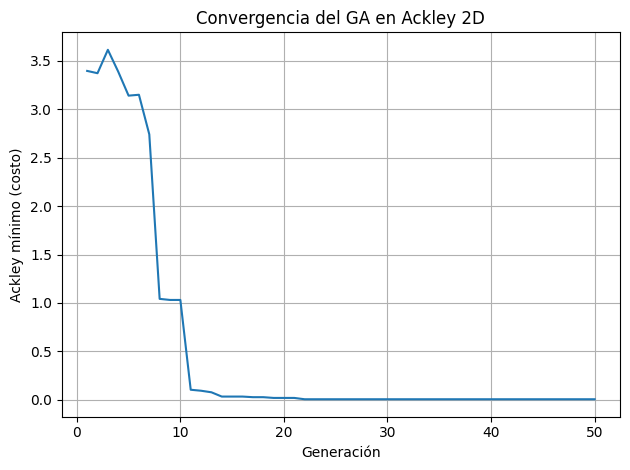

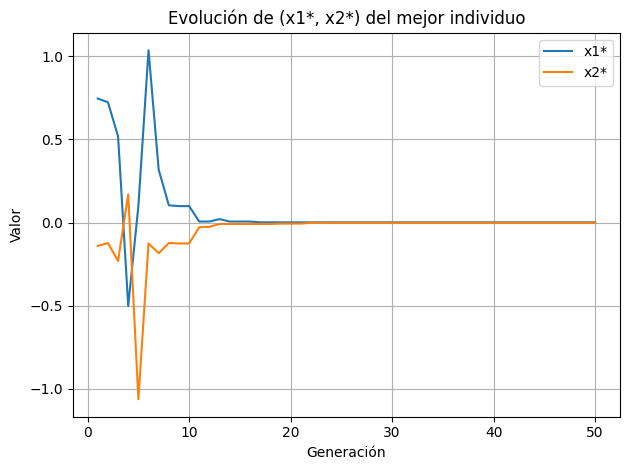

In [78]:
# IMPLEMENTACIÓN
print("IMPLEMENTACIÓN")


# ================== PARAMETROS DE ARRANQUE ==================
numero_individuos = 60
longitud_cromosoma = 12
generaciones = 50
porcentaje_seleccion = 0.6
par_cromosomas = int(numero_individuos/2)
tasa_mutacion = 0.01 # Esto requiere ser un valor entre bajo
max = 5
min = -max
tamaño_torneo=3

# ==================  HISTORICO ==================
historico = {
    "generacion": [],
    "mejor_x1": [],
    "mejor_x2": [],
    "mejor_fitness": []
}

# ================== ALGORITMO GENÉTICO ==================

# PASO 1 | Creamos la población
poblacion_x1 = iniciar_población(numero_individuos,longitud_cromosoma)
poblacion_x2 = iniciar_población(numero_individuos,longitud_cromosoma)
print(f"[PASO 1] Población X1 inicial: \n{poblacion_x1}\n")
print(f"[PASO 1] Población X2 inicial: \n{poblacion_x2}\n")




for i in range(generaciones):
    print(f"========= Generación {i+1}\n")
    # Paso 2 | Aplicamos el cruzamiento
    cruza_x1, cruza_x2 = cruzamiento(poblacion_x1,poblacion_x2,par_cromosomas)


    # Paso 3 | Aplicamos la mutación
    mutados_x1 = mutacion(cruza_x1,tasa_mutacion)
    mutados_x2 = mutacion(cruza_x2,tasa_mutacion)
    print(f"[PASO 3] Población después de la mutación: \n{mutados_x1}\n")

    # Paso 4 | Selección de la nueva generación
    seleccion_x1, seleccion_x2 = poblacion_torneo(mutados_x1, mutados_x2, k=tamaño_torneo, xmin=min, xmax=max)

    poblacion_x1 = seleccion_x1
    poblacion_x2 = seleccion_x2

    analisis(historico, i, poblacion_x1, poblacion_x2, min, max)



# ================= RESULTADOS =================
# Mejor de la última generación (en términos de Ackley positivo)

graficar_historico(historico)

